## **Test technique ILLUIN Technology** 

---



---



### **Sommaire**

###1.   Chargement des données et creation d'un nouveau dataset
###2.   Analyse des données et choix de la méthode
###3.   Fonctionnement du modèle
###4.   Evaluation du modèle

---



---







###1. Chargement des données et creation d'un nouveau dataset

Quand on prend en entrée un dataset de squad, la première étape est de créer un nouveau dataset exploitable pour notre modèle. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/Othercomputers/Mon Ordinateur portable/illuin_test

/content/drive/Othercomputers/Mon Ordinateur portable/illuin_test


In [ ]:
from src.load_data import load_raw_data

question_context,context = load_raw_data('data/train-v2.0.json')

In [ ]:
question_context.head()

,question,context
0,When did Beyonce start becoming popular?,1
1,What areas did Beyonce compete in when she was...,1
2,When did Beyonce leave Destiny's Child and bec...,1
3,In what city and state did Beyonce grow up?,1
4,In which decade did Beyonce become famous?,1


In [ ]:
context.head()

,idc,context
0,1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,2,Following the disbandment of Destiny's Child i...
2,3,"A self-described ""modern-day feminist"", Beyonc..."
3,4,"Beyoncé Giselle Knowles was born in Houston, T..."
4,5,Beyoncé attended St. Mary's Elementary School ...


On choisit de séparer les contextes des questions pour les raisons suivantes :

*   On evite la redondance des contextes dans le dataset
*   Cette façon de stocker nous donne deux approches immédiate pour le problème: **La classification** et **la similarité**



### 2 . Analyse des données et choix de la méthode

**a.) Pourquoi pas la classification ?**

Nous n'avons pas choisit la piste de classification pour les raisons suivantes:

*   On a trop de classes (près de $20000$ contextes) ce qui fait une probabilité de l'ordre de $10^{-4}$ de prédire la bonne classe.
*   On a tenté une classification rapide grâce a Catboost (car il est très simple et prend directement le text en entrée) et on a eu quasiment 0 de accuracy.



In [ ]:
print("On a {} classes dans le dataset".format(context.shape[0]))

On a 19035 classes dans le dataset


**b.) Une approche basé sur la similarité**

On a finalement décider de se tourner vers une méthode qui étudierait la similarité entre la question et le contexte. Les principaux enjeux étaient:


*   Trouver un moyen de comparer une question et un contexte
*   Pouvoir comparer rapidement pour tous les contextes (car on a beaucoup de contexte)



###3. Fonctionnement du modèle

**a.) Le preprocessing du texte**

Puis qu'on essaye de faire une similarité entre texte, on essaye d'avoir le moins de mots possible et de faire en sorte que les mots similaire soit identiques. D'où les étapes suivante: 

*   Lower le texte (minuscule)
*   remplacer tous les caractères accentués par leur version non accentué (Car on par du principe que les textes sont anglais)
*   supprimer toutes les ponctuations
*   supprimer tous les stopwords
*   stemming puis lematisation du texte (pour avoir le plus de mots réels possible)



In [ ]:
from src.preprocess import preprocess

print("Question initiale : "+question_context.question[0]+"\n")
print("Question preprocesser : "+preprocess(question_context.question[0]))

Question initiale : When did Beyonce start becoming popular?

Question preprocesser : beyonc start becom popular


In [ ]:
print("\n Contexte preprocesser : "+preprocess(context.context[0])+"\n")


 Contexte preprocesser : beyonc gisel knowlescart bijɒnseɪ beeyonsay born septemb 4 1981 american singer songwrit record produc actress born rais houston texa perform variou sing danc competit child rose fame late 1990 lead singer rb girlgroup destini child manag father mathew knowl group becam one world bestsel girl group time hiatu saw releas beyonc debut album danger love 2003 establish solo artist worldwid earn five grammi award featur billboard hot 100 numberon singl crazi love babi boy



**b.) Une premire approche: TF-IDF**

La première approche naturelle de similarité qui nous est venu à l'esprit était la suivante:

*   Créer un modèle tf-idf basé l'ensemble des contextes
*   pour chaque nouvelle question, calculer son vecteur tf-idf puis calculer son cosine similarité avec tous les vecteurs des contextes.
*   retourner le contexte avec la plus grande cosine similarité

Cette approche nous a plus ou moins motivé dans la piste la similarité car on obtenait une Accuracy d'environ $40$% sur les les données d'évalution. Cependant elle comportait les limites suivantes:
*   Les questions peuvent être posées en utilisant les synonymes, dans ce cas tf-idf ne sera pas en mesure de  détecter la similarité
*   L'Orthographe peut être légerement différent (à cause d'une erreur ou du stemming) dans la question et le contexte ce qui nuit également au modèle

En prenant ces contraintes en compte, on a abouti au modèle décrit dans la partie suivante.


**c.) Notre modèle**

**idée générale**
***
De façon génerale, pour prédire le meilleure contexte correspondant à une question $Q_i$, on calcule la similarité entre la question et tous les contextes et ensuite on predit le contexte le plus similaire. \\
Pour calculer la similarité entre une question $Q_i$ et un contexte $C_j$ l'idée est la suivante:
*   On  preprocesse la question avec le preprocessing definit précédement
*   On calcule on **embedding** pour chaque mot de la question
*   Pour chaque mot de la question on calculer sa meilleure similarité cosine avec tous les mots du contexte $C_i$ dont on a preprocessé et calculé les embedding en amont
*   On selection les top K (un paramètre du modèle) meilleur score trié par ordre decroissant
*   On fait une moyenne pondérée dans cette ordre avec les poids de la moyenne identiquement égaux (ce qui correspond à une simple moyenne) mais entraînable par la suite pour améliorer le score

Bien evidement, cette implémentation semble très couteuse en calcul mais grâce à une bonne vectorisation des calcules, la plupart des étapes se resume en quelques produits matriciels ce qui permet de considérerablement augmenter la vitesse de calcule. En effet pour une approche naïve, la prediction d'un lot de 1000 se faisait en une vingtaine de minute tandis qu'avec une approche vectoriser elle se faisait en moins de 10 seconde se l'ensemble de test.

**Implémentation et vectorisation**
****
L'un des gros enjeux de la méthodes précédante était la calculabilité. C'est pourquoi il fallait être aussi efficient que possible dans la façon d'implémenter, d'autant plus que je souhaitais rendre une partie de modèle entraînable.
*   La première étape pour faire une bonne implémentation est de normaliser (en norme l2) tous les embbeding. Ainsi, la cosine similarité entre un mot $m_1$ et $m_2$ devient tout simplement $<m_1,m_2>$ et donc la matrice de similarité entre un ensemble de mots $M1 = [mot_1, mot_2,...,m_{n_1}]^T et M2 = [mot'_1,mot'_2,..., mot'_{n_2}]^T $ est $ S = M_1M_2^T$
*   Ainsi avec la remarque précedente, la méthode précedente se resume à la formule suivante pour une question $Q_i = [mot_1,...,mot_{n_i}]$, on a:  
$prediction(Q_i) = \frac{(P_iW)^TSmartMax(Q_iC^T)}{(P_iW)^T[1,..,1]^T}$ avec:
>> $P_i$: matrice de projection permetant de selectionner les K meilleures scores \\
$W$: vecteur de poids entrainable. elle est initialisé à $[1,..,1]$. Dans ce cas c'est exactement la moyenne qui des K meilleure score qui est calculé \\
$C^T$: vecteur de tous mots de tous les contextes vectoriser dans un ordre précis et calculer à la creation du modèle
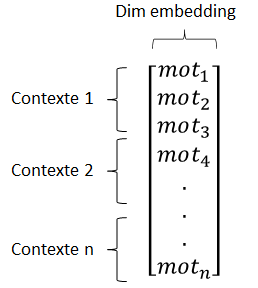
*  
>>$SmartMax$: fonction qui calule maximum sur un axis d'une matrice en se souvenant de la partie  de la matrice qui correspond à chaque contexte grace à un vecteur de correspondance

* Un fois qu'on est capable de prédire vectoriellement pour une question donnée, on peut facilement prédire globlament pour $N$ questions en remplacant $Q_i$ dans la formule précedente par $Q = [Q_1,...,Q_N]^T$ et en faisant quelques petits ajustement supplémentaire. \\
Cette méthode ne permet de prédire qu'un nombre limité de question en parallèle selon la RAM. Je suis limité à 1000 questions en parallèle sur Colab pour 10 secondes à peu près par paquet de 1000.

**Embedding**
****
Pour l'embadding nous avons choisit une version très compréssée et préentraînée (23 Mo au lieu de 10Go) de **Fasttext** pour plusieurs raison:
*   Fasttext était le seul modèle d'embadding que je connaissais capable d'inférer sur les mots inconnus. De plus vu qui est entraîné grace au char n-gram, les mots différant légère orthographiquement son similaire.
*   De plus, sachant que les contexte son censé changé d'un dataset à l'autre, je ne pouvais pas entraîner un autre modèle d'embadding (Word2Vec on Glove) sur tous les mots de mon corpus car dès qu'il rencontrerait un nouveau mot dans un autre contexte, il ne saurait inférer.
*   J'ai choisit un modèle préentrainer car compte tenu du temps que j'avais, je ne pouvais pas entraîner un modèle fasttext sur mon propre corpus

Ainsi, utiliser une meilleure version de fasttext ou un autre embedding plus performant pour être une piste d'amélioration du modèle


In [ ]:
#!pip install compress-fasttext

In [ ]:
import compress_fasttext
fasttext_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext/fasttext.model')

In [ ]:
print("\nLe modèle à t-il le mot beyonce : {}".format(fasttext_model.has_index_for("boyonce"))+"\n")
print("Une inférence de beyonce est : {}".format(fasttext_model['beyonce'][0:5])+"\n")
print("La similarité entre beyonc et beyonce est : {}".format(fasttext_model.similarity("beyonce","beyonc"))+"\n")


Le modèle à t-il le mot beyonce : False

Une inférence de beyonce est : [-0.07390039  0.01569077  0.00367612  0.07486065 -0.0496726 ]

La similarité entre beyonc et beyonce est : 0.844028115272522



### 3. Evalution du modèle

**a) métrique**

La métrique qui a été choisit pour évaluer le modèle est un métrique basée sur la prédiction des $k$ contextes les plus probables avec $k$ paramétrable. si le contexte se trouve parmis les les k on considère qu'on a trouvé sinon on a raté. Lorsque $k = 1$ on retrouvre l'accuracy habituelle.

**b) live test**

**Comparaison des métriques**
*****

In [ ]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print('Using gpu: %s ' % torch.cuda.is_available())

In [ ]:
# Chargement puis preproccessing des données

test_question_context,test_context = load_raw_data('data/dev-v2.0.json')
test_pre_context = test_context.copy()
test_pre_context['context'] = test_pre_context['context'].apply(lambda x:preprocess(x))
test_pre_question_context = test_question_context.copy()
test_pre_question_context['question'] = test_pre_question_context['question'].apply(lambda x:preprocess(x))

In [ ]:
from src.model import IlluinNetwork

#on crée le modèle
model = IlluinNetwork(embedding_model = fasttext_model)

#on adapte le modèle au contexte
model.fit_context(test_pre_context)

model.to(device)

In [ ]:
# sur une echantillon de 100
from src.utils import eval
test_data = test_pre_question_context.sample(100)
eval(model,test_data,batch_size =100, k =1, device =device)

evaluation of 100 data
	 batch : 100 correct : 73 Acc : 0.7300
1 - Acc: 0.7300


In [ ]:
eval(model,test_data,batch_size =100, k =3, device =device)

evaluation of 100 data
	 batch : 100 correct : 88 Acc : 0.8800
3 - Acc: 0.8800


**Evaluation globle sur le dev**
****

In [ ]:
eval(model,test_pre_question_context,batch_size =1000, k =3, device =device)

evaluation of 11873 data
	 batch : 1000 correct : 848 Acc : 0.8480
	 batch : 2000 correct : 845 Acc : 0.8450
	 batch : 3000 correct : 818 Acc : 0.8180
	 batch : 4000 correct : 793 Acc : 0.7930
	 batch : 5000 correct : 824 Acc : 0.8240
	 batch : 6000 correct : 814 Acc : 0.8140
	 batch : 7000 correct : 831 Acc : 0.8310
	 batch : 8000 correct : 822 Acc : 0.8220
	 batch : 9000 correct : 822 Acc : 0.8220
	 batch : 10000 correct : 829 Acc : 0.8290
	 batch : 11000 correct : 833 Acc : 0.8330
	 batch : 11873 correct : 730 Acc : 0.8362
3 - Acc: 0.8262


**Utilisation du modèle entraîné**
*****

On a utilisé la fonction train de utils.py pour entraîne les poids de la moyenne (les valeurs du vecteur $X$) sur les données d'entraînement pour essayer d'améliorer score. Compte tenu de la durée d'entraînement, on a juste fait une seule epoch. \\
On charge les paramètre du modèle qu'on  a entraîné en amont.

In [ ]:
model.load_state_dict(torch.load("trained models/model1", map_location=lambda storage, loc: storage))
eval(model,test_pre_question_context,batch_size =1000, k =3, device =device)

evaluation of 11873 data
	 batch : 1000 correct : 824 Acc : 0.8240
	 batch : 2000 correct : 828 Acc : 0.8280
	 batch : 3000 correct : 827 Acc : 0.8270
	 batch : 4000 correct : 824 Acc : 0.8240
	 batch : 5000 correct : 852 Acc : 0.8520
	 batch : 6000 correct : 834 Acc : 0.8340
	 batch : 7000 correct : 836 Acc : 0.8360
	 batch : 8000 correct : 817 Acc : 0.8170
	 batch : 9000 correct : 818 Acc : 0.8180
	 batch : 10000 correct : 823 Acc : 0.8230
	 batch : 11000 correct : 831 Acc : 0.8310
	 batch : 11873 correct : 718 Acc : 0.8225
3 - Acc: 0.8281


**Livrable**
****


*   Un module python permettant d'évaluer le modèle sur un dataset de SQUAD (evalate_model.py)
*   Un module permettant de prédire le contexte d'une question (predict_question.py) en utilisant certains fichiers préalablement générer par un module python permettant de s'adapter au contexte (fit_context.py) 



In [ ]:
!python fit_context.py "data/dev-v2.0.json"

loading dataset...
preprocessing...
loading Fasttext...
fitting context
creating file


In [ ]:
!python predict_question.py "what is your name"

loading Fasttext...
loading context file...
preprocessing de la question
1 sur 1
le contexte est : In this dioxygen, the two oxygen atoms are chemically bonded to each other. The bond can be variously described based on level of theory, but is reasonably and simply described as a covalent double bond that results from the filling of molecular orbitals formed from the atomic orbitals of the individual oxygen atoms, the filling of which results in a bond order of two. More specifically, the double bond is the result of sequential, low-to-high energy, or Aufbau, filling of orbitals, and the resulting cancellation of contributions from the 2s electrons, after sequential filling of the low σ and σ* orbitals; σ overlap of the two atomic 2p orbitals that lie along the O-O molecular axis and π overlap of two pairs of atomic 2p orbitals perpendicular to the O-O molecular axis, and then cancellation of contributions from the remaining two of the six 2p electrons after their partial filling of th

In [ ]:
!python evaluate_model.py data/dev-v1.1.json -n 1000 -k 1

loading dataset...
preprocessing...
loading Fasttext...
fitting context
evaluation of 1000 data
	 batch : 100 correct : 70 Acc : 0.7000
	 batch : 200 correct : 70 Acc : 0.7000
	 batch : 300 correct : 68 Acc : 0.6800
	 batch : 400 correct : 65 Acc : 0.6500
	 batch : 500 correct : 62 Acc : 0.6200
	 batch : 600 correct : 73 Acc : 0.7300
	 batch : 700 correct : 68 Acc : 0.6800
	 batch : 800 correct : 75 Acc : 0.7500
	 batch : 900 correct : 64 Acc : 0.6400
	 batch : 1000 correct : 68 Acc : 0.6800
1 - Acc: 0.6830
